# 1. Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Read and Preprocessing data

### 2.1 Read data

In [2]:
df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [3]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [5]:
df.label.value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

### 2.2 Split data into X, y

In [6]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

### 2.3 Encoding

In [7]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

### 2.4 Text preprocessing

In [8]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

# 3. Building deep learning model

In [9]:
max_words = 10000
max_len = 50
embedding_dim = 64

### 3.1 Model architecture

In [10]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(hid_layer)
output_layer = Dense(6, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [11]:
# model = Sequential()     
# model.add(Embedding(10000, 32, input_length=50))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D(keepdims=True))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(6, activation='softmax'))

### 3.2 Compile model

In [12]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 50)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 50, 64)               640000    ['embedding_input[0][0]']     
                                                                                              

In [13]:
GlobalMaxPooling1D??

Init signature: GlobalMaxPooling1D(*args, **kwargs)
Source:        
@keras_export("keras.layers.GlobalMaxPooling1D", "keras.layers.GlobalMaxPool1D")
class GlobalMaxPooling1D(GlobalPooling1D):
    """Global max pooling operation for 1D temporal data.

    Downsamples the input representation by taking the maximum value over
    the time dimension.

    For example:

    >>> x = tf.constant([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
    >>> x = tf.reshape(x, [3, 3, 1])
    >>> x
    <tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
    array([[[1.], [2.], [3.]],
           [[4.], [5.], [6.]],
           [[7.], [8.], [9.]]], dtype=float32)>
    >>> max_pool_1d = tf.keras.layers.GlobalMaxPooling1D()
    >>> max_pool_1d(x)
    <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
    array([[3.],
           [6.],
           [9.], dtype=float32)>

    Args:
      data_format: A string,
        one of `channels_last` (default) or `channels_first`.
        The ordering of the dimensions in the inp

### 3.3 Traning the model

In [14]:
batch_size = 128
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
125/125 [==============================] - 30s 176ms/step - loss: 1.7526 - accuracy: 0.3039 - precision: 0.3127 - recall: 0.0481 - val_loss: 1.7588 - val_accuracy: 0.3540 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 12s 98ms/step - loss: 1.5797 - accuracy: 0.3563 - precision: 0.4860 - recall: 0.0369 - val_loss: 1.7365 - val_accuracy: 0.3880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 8s 63ms/step - loss: 1.5165 - accuracy: 0.3996 - precision: 0.5935 - recall: 0.0748 - val_loss: 1.6945 - val_accuracy: 0.4600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 4s 30ms/step - loss: 1.3997 - accuracy: 0.4717 - precision: 0.6912 - recall: 0.1834 - val_loss: 1.5451 - val_accuracy: 0.5590 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 3s 20ms/ste

# 4. Evaluation and Visullize results

### 4.1 Evaluate the model

In [15]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

63/63 [==============================] - 0s 4ms/step - loss: 0.2054 - accuracy: 0.9170 - precision: 0.9284 - recall: 0.9075
Loss: 0.21, Accuracy: 0.92, Precision: 0.93, Recall: 0.91


In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

### 4.2 Visullize results

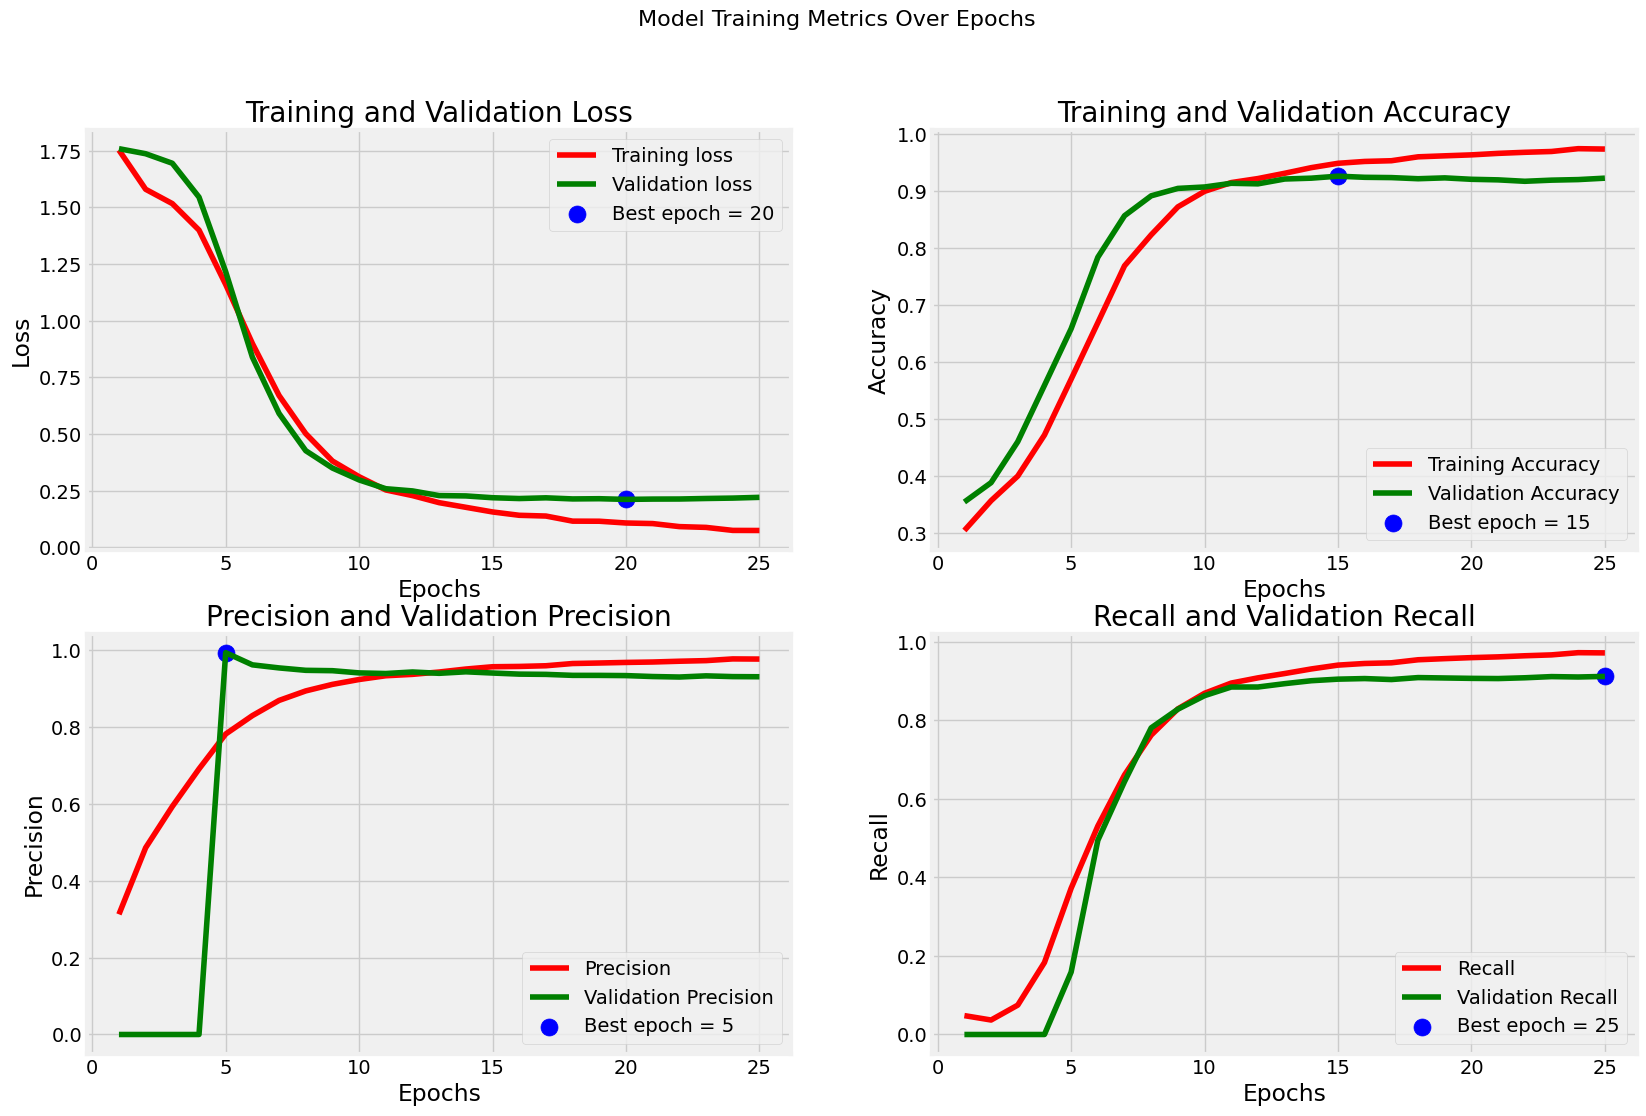

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [18]:
y_true=[]
for i in range(len(ts_y)):
    x = np.argmax(ts_y[i]) 
    y_true.append(x)

In [19]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

63/63 [==============================] - 0s 2ms/step


array([4, 4, 4, ..., 2, 2, 1])

<Axes: >

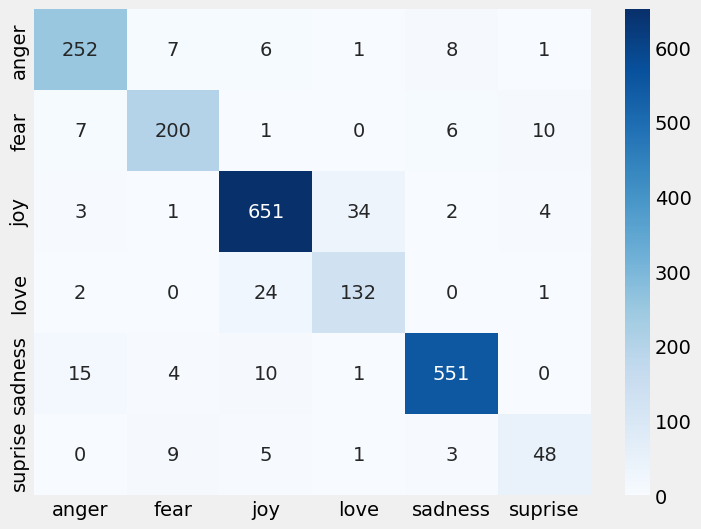

In [20]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5:'suprise'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [21]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       275
           1       0.90      0.89      0.90       224
           2       0.93      0.94      0.94       695
           3       0.78      0.83      0.80       159
           4       0.97      0.95      0.96       581
           5       0.75      0.73      0.74        66

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.92      0.92      0.92      2000



# 5. Save model

In [22]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 6. Prediction function

In [23]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    
    model = load_model(model_path)
    
    
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])
    
    emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5:'suprise'}
    
    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 0s 150ms/step


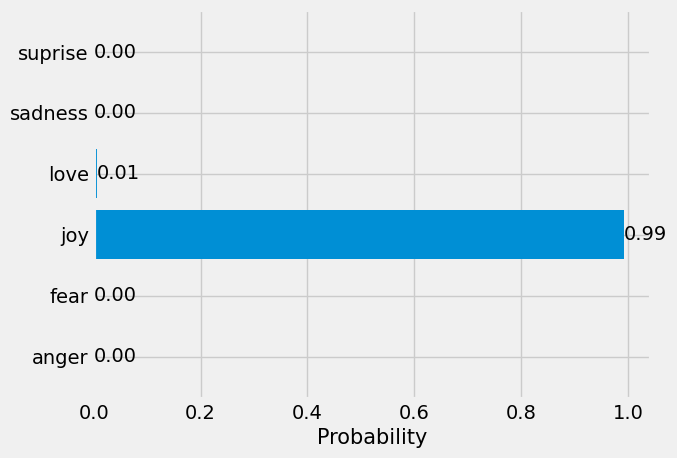

In [24]:
txt = 'I am very happy to finish this project'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

1/1 [==============================] - 0s 126ms/step


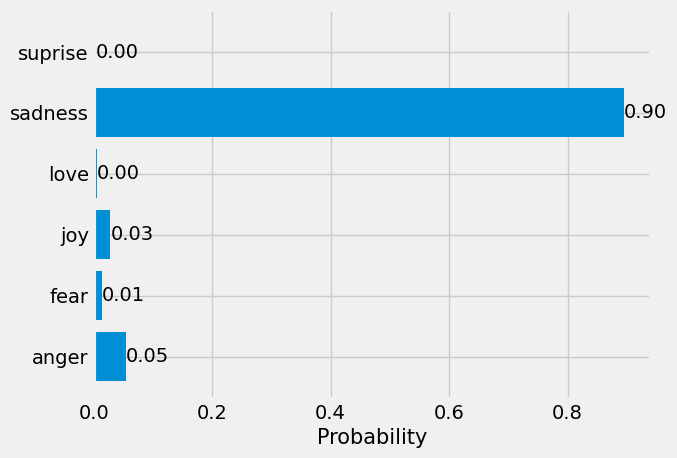

In [26]:
txt = 'I am very sad'
predict(txt, 'nlp.h5', 'tokenizer.pkl')